C:\Users\framc\AppData\Local\Temp\ipykernel_3508\4041663058.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_data = torch.load('M1_testing_data.pt')
C:\Users\framc\A

Predicted pressure drop: 0.0
True pressure drop: 0.0013042570790275931


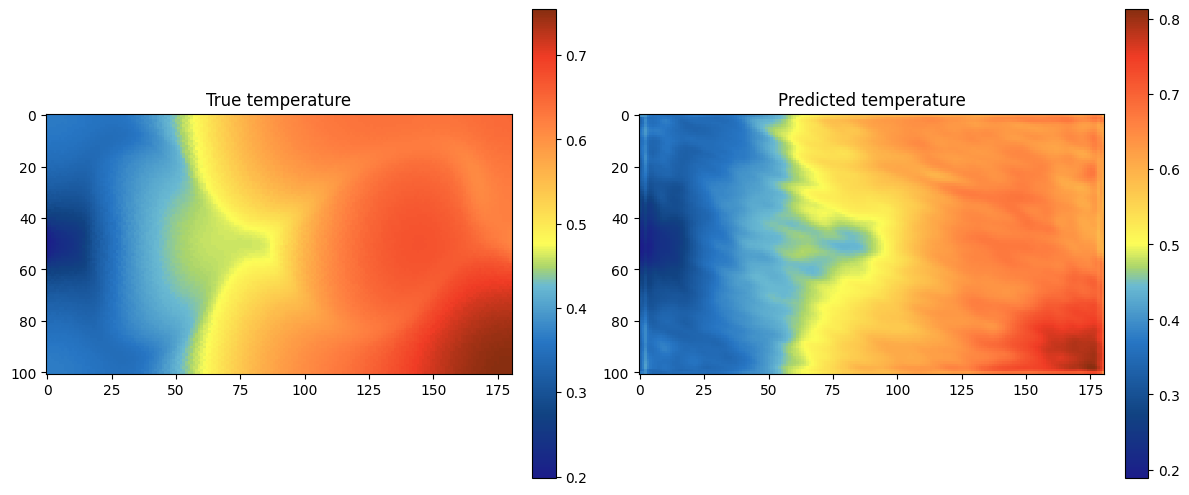

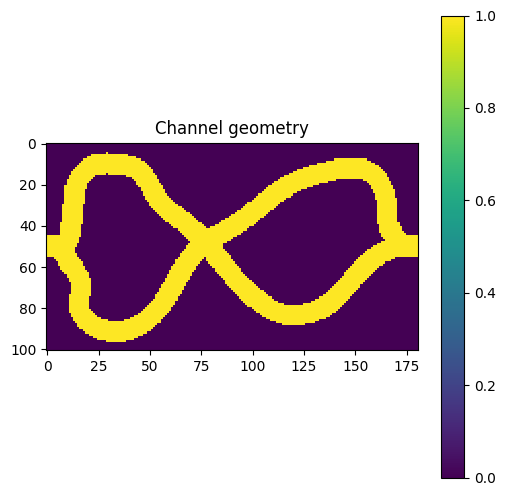

In [13]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from architecture import HeatChannelNet
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

test_data = torch.load('M1_testing_data.pt')
sample_index = 29

color_stops = [
    (0.0,   (28/255, 29/255, 138/255)),
    (0.1355, (17/255, 67/255, 130/255)),
    (0.29,  (39/255, 118/255, 196/255)),
    (0.41,  (106/255, 186/255, 210/255)),
    (0.45,  (170/255, 213/255, 108/255)),
    (0.5,   (252/255, 253/255, 88/255)),
    (0.76,  (255/255, 128/255, 65/255)),
    (0.9,   (240/255, 60/255, 37/255)),
    (1.0,   (136/255, 46/255, 16/255))
]
cmap_name = 'custom_blue_yellow_red'
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, color_stops)
custom_cmap.set_bad(color='black')

model_net = HeatChannelNet()
model_net.load_state_dict(torch.load('M1_performance_predictor.pth'))
model_net.eval()

heat_source_sample = test_data['heat_source'][sample_index].unsqueeze(0).unsqueeze(0)
channel_geometry_sample = test_data['channel_geometry'][sample_index].unsqueeze(0).unsqueeze(0)
inlet_velocity_sample = test_data['inlet_velocity'][sample_index].unsqueeze(0).unsqueeze(0)
pressure_drop_true = test_data['pressure_drop'][sample_index]
temperature_true = test_data['temperature'][sample_index]

with torch.no_grad():
    pressure_drop_pred, temperature_pred = model_net(
        heat_source_sample, channel_geometry_sample, inlet_velocity_sample
    )
    
    print('Predicted pressure drop:', pressure_drop_pred.item())
    print('True pressure drop:', pressure_drop_true.item())
    
    temperature_pred_np = temperature_pred.squeeze().cpu().numpy()
    temperature_true_np = temperature_true.cpu().numpy()
    
    global_min = temperature_true_np.min()
    global_max = temperature_true_np.max()
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    im1 = plt.imshow(
        temperature_true_np,
        cmap=custom_cmap,
        interpolation='nearest',
        vmin=global_min
    )
    plt.title('True temperature')
    plt.colorbar(im1, fraction=0.046, pad=0.04)
    plt.subplot(1, 2, 2)
    im2 = plt.imshow(
        temperature_pred_np,
        cmap=custom_cmap,
        interpolation='nearest'
    )
    plt.title('Predicted temperature')
    plt.colorbar(im2, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(6, 6))
    channel_geometry_np = channel_geometry_sample.squeeze().cpu().numpy()
    plt.imshow(channel_geometry_np, interpolation='nearest')
    plt.title('Channel geometry')
    plt.colorbar()
    plt.show()


## Error map:

Mean Absolute Error (MAE): 0.0096


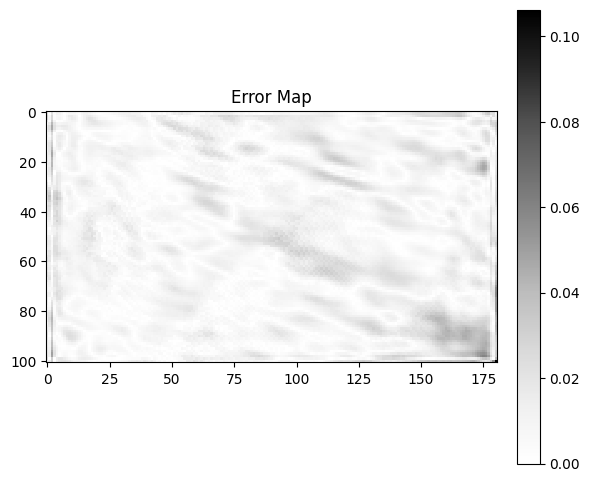

In [17]:
error_map = np.abs(temperature_pred_np - temperature_true_np)

mae = np.mean(np.abs(error_map))

print(f"Mean Absolute Error (MAE): {mae:.4f}")

plt.figure(figsize=(6, 6))
im = plt.imshow(
    error_map,
    cmap='Greys',
    interpolation='nearest',
    vmin=0,
    vmax=np.max(np.abs(error_map))
)
plt.title('Error Map')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()
